### Pytorch를 비롯해 기타 필요한 패키지를 불러옵니다.

In [0]:
import torch
import torch.nn as nn #
import torch.nn.functional as F #
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다. 
import torchvision.datasets as vision_dsets
import torchvision.transforms as transforms # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt # 시각화를 위한 패키지입니다.

### Hyper-parameter 세팅 및 기타 변수 지정

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # pytorch0.4.0 이상 버젼에서 gpu 설정하는 방식, tensor.to(device) 이런식으로 사용
lr = 0.0002
batch_size = 128
best_acc = 0  # best test accuracy
num_epoch = 10 # 학습시킬 에폭 수

### 데이터 로딩

In [3]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : ???

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
data_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('[info] # of train batch : ' ,len(data_loader)*batch_size)

==> Preparing data..
[info] # of train batch :  50048


## 데이터가 잘 불러와졌는지 확인해주세요~

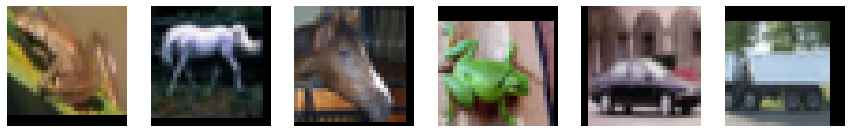

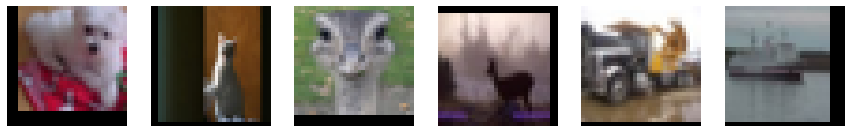

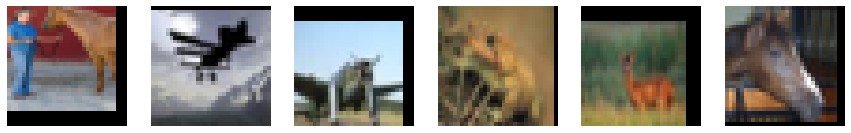

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff54bd1a610>> ignored


In [0]:
# 우리 모델에서는 -1 ~ 1 사이의 값을 뽑아주기 때문에, 이미지 출력을 위해 0 ~ 1 사이 값으로 변환하는 함수가 필요합니다.
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def showImages(image, row):
  
    for _ in range(row):  
  
        idx = np.random.choice(batch_size, 6)     # 0 ~ 127 의 정수 중 6 개를 임의로 선택
        images =image.numpy()[idx].transpose(0,2,3,1)         # 선택된 index 에 해당하는 이미지를 가져옴
        plt.figure(figsize = (15, 90))     # 세로 길이 15, 가로 길이 15 * 6 의 화면 생성

    for i in range(161, 167):    
    
        plt.subplot(i)
        plt.imshow(images[i - 161])
        plt.xticks([])
        plt.yticks([])    
    
    plt.show()  

for i, (image, labels) in enumerate(data_loader): 
  
    showImages(image.squeeze(), 3)
    break

### 이미지 출력 함수

In [0]:
def test_and_show(G, fixed_z):
    G.eval()
    fake_images = G(fixed_z).view(-1, 32, 32, 3)  
    fake_images = (fake_images+1)/2
    images_to_show = fake_images.data.cpu().numpy()
    images_row = images_to_show[:6] 

    plt.figure(figsize=(10,60))
    for a in range(161, 167):    
        plt.subplot(a)
        plt.imshow(images_row[a-161])
        plt.xticks([])
        plt.yticks([])    
    plt.show() 

# GAN with a MLP

### 직접 입력해봅시다

In [0]:
# 가로 세로 체널
img_dim = 32*32*3

# 임베딩 디맨션을 설정해주세요! (20 ~ 100)
z_dim = 100

# Discriminator의 중간 레이어 디맨션을 설정해주세요! (200 ~ 400)
D_intermediate_dim1 = img_dim // 2
D_intermediate_dim2 = img_dim // 4
D_intermediate_dim3 = img_dim // 8
D_intermediate_dim4 = img_dim // 16

# Generator의 중간 레이어 디맨션을 설정해주세요! (200 ~ 400)
G_intermediate_dim1 = img_dim // 2
G_intermediate_dim2 = img_dim // 4
G_intermediate_dim3 = img_dim // 8
G_intermediate_dim4 = img_dim // 16

### Discriminator 입니다

In [0]:
# Discriminator
D = nn.Sequential(
    
    nn.Linear(img_dim, D_intermediate_dim1),
    nn.LeakyReLU(0.01),
    nn.Linear(D_intermediate_dim1, D_intermediate_dim2),
    nn.LeakyReLU(0.01),
    nn.Linear(D_intermediate_dim2, D_intermediate_dim3),
    nn.LeakyReLU(0.01),
    nn.Linear(D_intermediate_dim3, D_intermediate_dim4),
    nn.LeakyReLU(0.01),
    nn.Linear(D_intermediate_dim4, 1),
    nn.Sigmoid() # 0 ~ 1

).to(device)

### Generator 입니다

In [0]:
# Generator 
G = nn.Sequential(
    
    nn.Linear(z_dim, G_intermediate_dim1),
    nn.ReLU(),
    nn.Linear(G_intermediate_dim1, G_intermediate_dim2),
    nn.ReLU(),
    nn.Linear(G_intermediate_dim2, G_intermediate_dim3),
    nn.ReLU(),
    nn.Linear(G_intermediate_dim3, G_intermediate_dim4),
    nn.ReLU(),
    nn.Linear(G_intermediate_dim4, img_dim),
    nn.Tanh() # -1 ~ 1

).to(device)

### Loss 및 Optimizer 선정

In [0]:
# Binary cross entropy loss and Adam optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

In [0]:
# test에서 항상 뽑아볼 수 있는 고정된 z를 사전에 뽑아둡니다.
fixed_z = torch.randn(batch_size, z_dim).to(device)

### Training 코드입니다

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [0/200], Step[300/391], d_loss: 1.3940, g_loss: 0.6873, D(x): 0.50, D(G(z)): 0.50


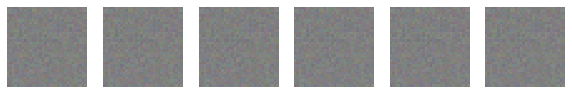

Epoch [1/200], Step[300/391], d_loss: 1.3955, g_loss: 0.6874, D(x): 0.50, D(G(z)): 0.50


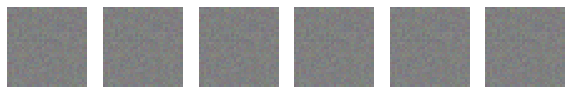

Epoch [2/200], Step[300/391], d_loss: 1.3940, g_loss: 0.6874, D(x): 0.50, D(G(z)): 0.50


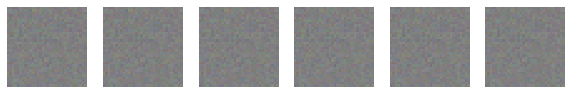

Process Process-25:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python2.7/dist-packages/torch/multiprocessing/queue.py", line 21, in recv
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
    buf = self.recv_bytes()
KeyboardInterrupt
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff54bd7bbd0>> ignored


KeyboardInterrupt: ignored

In [0]:
# Start training
for epoch in range(num_epoch):
    for i, (images, _) in enumerate(data_loader):
        
        G.train()
        D.train()
      
        # (B,3,32,32) => (B,3*32*32)
        images = images.view(-1, 32*32*3).to(device)
        batch_size = images.size(0)# batch_size 를 다시 선언해 준 이유는?? 를 다시 잡아주는 이유는?
        
        # 진짜라는 label, 가짜라는 label을 만들어줍니다.
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        
        #============= Train the discriminator =============#
        
        # Discriminator에게 진짜 이미지를 진짜라고 가르쳐 줍니다.
        outputs = D(images) # 진짜 이미지를 Discriminator에 넣어줍니다.
        d_loss_real = criterion(outputs, real_labels) # Discriminator가 진짜 이미지는 1로 판단하도록 로스를 발생시켜 줍니다.
        real_score = outputs
        
        # Discriminator에게 가짜 이미지를 가짜라고 가르쳐 줍니다.
        z = torch.randn(batch_size, z_dim).to(device) # latent vector z를 N(0,1)에서 random sampling 해줍니다.
        fake_images = G(z) # Generator에 z를 인풋으로 넣어줍니다.
        outputs = D(fake_images.detach()) # Discriminator에 가짜이미지를 넣어줍니다.
        d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 가짜 이미지는 0으로 판단하도록 로스를 발생시켜 줍니다.
        fake_score = outputs
        
        # Backprop + Optimize (Discriminator 업데이트!!)
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #=============== Train the generator ===============#
        
        # Generator가 Discriminator를 속여 가짜 이미지를 진짜로 판단하게끔 학습합니다. (ADVERSARIAL)
        z = torch.randn(batch_size, z_dim).to(device) # latent vector z를 N(0,1)에서 random sampling 해줍니다.
        fake_images = G(z) # Generator에 z를 인풋으로 넣어줍니다.
        outputs = D(fake_images) # Discriminator에 가짜이미지를 넣어줍니다.
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # Discriminator가 가짜 이미지를 1로 판단하도록 로스를 발생시켜 줍니다.
        
        # Backprop + Optimize (Generator 업데이트!!)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch, 200, i+1, len(data_loader), d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
        if (i+1) % 300 == 0:
            test_and_show(G, torch.randn(batch_size, z_dim).to(device))


### 샘플 이미지 뽑아보기

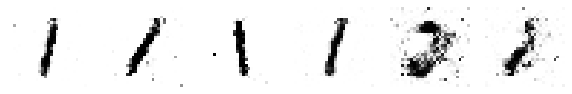

In [0]:
test_and_show(G, fixed_z)

# GAN with a CNN

### 테스트코드 입니다

In [0]:
def test_and_show(G, fixed_z):
    G.eval()
    fake_images = G(fixed_z).view(-1, 32, 32, 3)  
    fake_images = (fake_images+1)/2
    images_to_show = fake_images.data.cpu().numpy()
    images_row = images_to_show[:6] 

    plt.figure(figsize=(10,60))
    for a in range(161, 167):    
        plt.subplot(a)
        plt.imshow(images_row[a-161])
        plt.xticks([])
        plt.yticks([])    
    plt.show() 

### 직접 입력해봅시다

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # pytorch0.4.0 이상 버젼에서 gpu 설정하는 방식, tensor.to(device) 이런식으로 사용
lr = 0.0002
batch_size = 128
best_acc = 0  # best test accuracy
num_epoch = 10 # 학습시킬 에폭 수

# 가로 세로 체널
img_dim = 32*32*3

# 임배딩 디맨션
z_dim = 100


In [0]:
class ConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding, norm='none', activation='none', bias=True):
        super(ConvBlock, self).__init__()
    
    # Init Normalization
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(output_dim)
        elif norm == 'none':
            self.norm = None
      
    # Init Activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2)
        elif activation == 'none':
            self.activation = None
      
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding, bias=bias)
    
    def forward(self, x):
        x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

### Discriminator 입니다

In [0]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        curr_dim = 64
        layers = []
        layers += [ConvBlock(3, curr_dim, 4, 2, 1, activation='lrelu', bias=False)] # B,3,32,32 => B,64,16,16
    
    for _ in range(2):
        layers += [ConvBlock(curr_dim, curr_dim*2, 4, 2, 1, norm='bn', activation='lrelu', bias=False)] # B,64,16,16 => B,128,8,8=> B,256,4,4
        curr_dim *= 2

    layers += [ConvBlock(curr_dim, 1, 4, 1, 0, activation='sigmoid', bias=False)] # B,512,2,2 => B,512,1,1
    
    self.main = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1) #B
  

### Generator 입니다

In [0]:
# Generator 
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
    
        curr_dim = 64*4 # 512

        conv_layers = []
        conv_layers += [nn.ConvTranspose2d(z_dim, curr_dim, kernel_size=4, stride=1, padding=0, bias=False)] # B,100,1,1 => B,256,4,4
        conv_layers += [nn.BatchNorm2d(curr_dim)]
        conv_layers += [nn.ReLU()]

        for i in range(2):
            conv_layers += [nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False)] # B,256,4,4 => B,128,8,8 => B,64,16,16
            conv_layers += [nn.BatchNorm2d(curr_dim//2)]
            conv_layers += [nn.ReLU()]
            curr_dim //= 2
      
            conv_layers += [nn.ConvTranspose2d(curr_dim, 3, kernel_size=4, stride=2, padding=1, bias=False)] # B,64,16,16 => B,3,32,32
            conv_layers += [nn.Tanh()]

            self.main = nn.Sequential(*conv_layers)
    
    def forward(self, x):
        return self.main(x)

### Loss 및 Optimizer 선정

In [0]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# Binary cross entropy loss and Adam optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

In [0]:
# test에서 항상 뽑아볼 수 있는 고정된 z를 사전에 뽑아둡니다.
fixed_z = torch.randn(batch_size, z_dim, 1, 1).to(device)

### Training 코드입니다

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [0/200], Step[390/391], d_loss: 0.0419, g_loss: 6.4026, D(x): 0.97, D(G(z)): 0.01


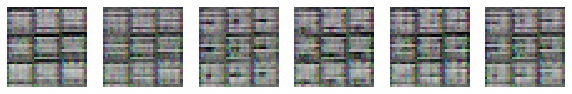

Epoch [1/200], Step[390/391], d_loss: 0.0444, g_loss: 5.9500, D(x): 0.98, D(G(z)): 0.02


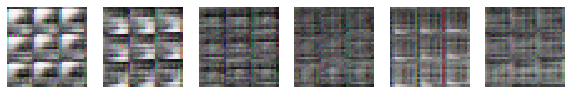

Epoch [2/200], Step[390/391], d_loss: 0.0468, g_loss: 7.0482, D(x): 0.98, D(G(z)): 0.01


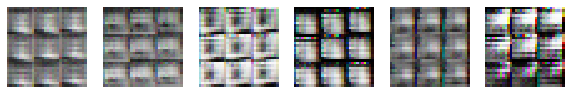

Epoch [3/200], Step[390/391], d_loss: 0.0167, g_loss: 7.3260, D(x): 0.99, D(G(z)): 0.01


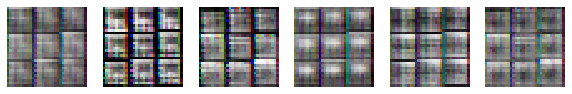

Epoch [4/200], Step[390/391], d_loss: 0.0134, g_loss: 8.0001, D(x): 1.00, D(G(z)): 0.01


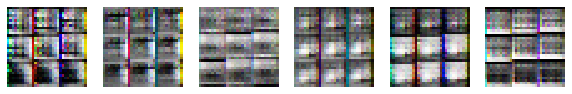

Epoch [5/200], Step[390/391], d_loss: 0.0162, g_loss: 6.8798, D(x): 0.99, D(G(z)): 0.01


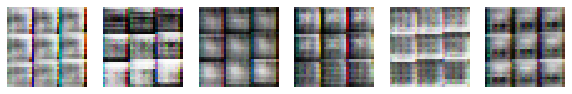

Epoch [6/200], Step[390/391], d_loss: 0.0302, g_loss: 9.1841, D(x): 0.99, D(G(z)): 0.00


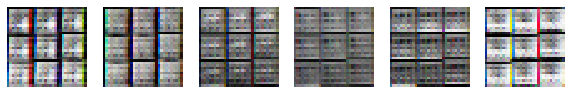

Epoch [7/200], Step[390/391], d_loss: 0.0197, g_loss: 6.8682, D(x): 0.99, D(G(z)): 0.00


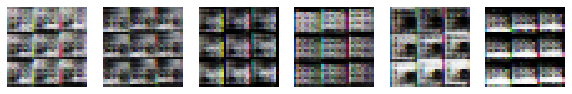

Epoch [8/200], Step[390/391], d_loss: 0.0108, g_loss: 9.5772, D(x): 0.99, D(G(z)): 0.00


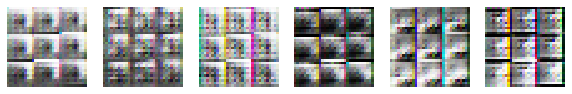

Epoch [9/200], Step[390/391], d_loss: 0.0215, g_loss: 6.4696, D(x): 1.00, D(G(z)): 0.02


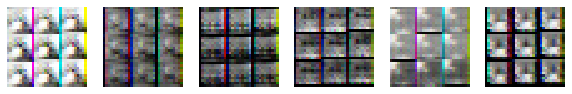

In [18]:
# Start training
for epoch in range(num_epoch):
    if (epoch) % 10 == 0:
        torch.save(G.state_dict(), './data/generator_cifar10.pkl')
        torch.save(D.state_dict(), './data/discriminator_cifar10.pkl')
    for i, (images, labels) in enumerate(data_loader):
        
        G.train()
        D.train()
        
        # (B,3,32,32) => (B,3*32*32)
        images = images.to(device)
        batch_size = images.size(0)# batch_size 를 다시 선언해 준 이유는?? 를 다시 잡아주는 이유는?
        
        # 진짜라는 label, 가짜라는 label을 만들어줍니다.
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        labels = labels.to(device)
        
        #============= Train the discriminator =============#
        
        # Discriminator에게 진짜 이미지를 진짜라고 가르쳐 줍니다.
        outputs = D(images) # 진짜 이미지를 Discriminator에 넣어줍니다.
        d_loss_real = criterion(outputs, real_labels) # Discriminator가 진짜 이미지는 1로 판단하도록 로스를 발생시켜 줍니다.
        real_score = outputs
        
        # Discriminator에게 가짜 이미지를 가짜라고 가르쳐 줍니다.
        z = torch.randn(batch_size, z_dim, 1, 1).to(device) # latent vector z를 N(0,1)에서 random sampling 해줍니다.
        fake_images = G(z) # Generator에 z를 인풋으로 넣어줍니다.
        outputs = D(fake_images.detach()) # Discriminator에 가짜이미지를 넣어줍니다.
        d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 가짜 이미지는 0으로 판단하도록 로스를 발생시켜 줍니다.
        fake_score = outputs
        
        # Backprop + Optimize (Discriminator 업데이트!!)
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #=============== Train the generator ===============#
        
        # Generator가 Discriminator를 속여 가짜 이미지를 진짜로 판단하게끔 학습합니다. (ADVERSARIAL)
        z = torch.randn(batch_size, z_dim, 1, 1).to(device) # latent vector z를 N(0,1)에서 random sampling 해줍니다.
        fake_images = G(z) # Generator에 z를 인풋으로 넣어줍니다.
        outputs = D(fake_images) # Discriminator에 가짜이미지를 넣어줍니다.
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # Discriminator가 가짜 이미지를 1로 판단하도록 로스를 발생시켜 줍니다.
        
        # Backprop + Optimize (Generator 업데이트!!)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 390 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch, 200, i+1, len(data_loader), d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
        if (i+1) % 390 == 0:
            test_and_show(G, torch.randn(batch_size, z_dim, 1, 1).to(device))


### 샘플 이미지 뽑아보기

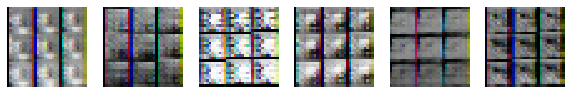

In [19]:
test_and_show(G, fixed_z)

### 학습시킨 모델을 저장시켜봅시다

In [0]:
# Save the trained parameters 
torch.save(G.state_dict(), './data/generator_cifar10.pkl')
torch.save(D.state_dict(), './data/discriminator_cifar10.pkl')